In [ ]:
pip install adjustText


In [ ]:
import numpy as np


In [ ]:
import pandas as pd

# Load data from CSV file
file_path = '/content/Nov30-Jan2UU.csv'  # Update this to your CSV file's path
df = pd.read_csv(file_path)

# Focus on the 'UTTERANCES' column
utterances_df = df[['UTTERANCES']]


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")  # Ensure you have this model downloaded

def preprocess_text(text):
    doc = nlp(text.lower())
    return " ".join([token.text for token in doc if token.is_alpha])

# Apply preprocessing
utterances_df['Processed'] = utterances_df['UTTERANCES'].apply(preprocess_text)


<ipython-input-17-c4b51c482bbe>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utterances_df['Processed'] = utterances_df['UTTERANCES'].apply(preprocess_text)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorize preprocessed utterances
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(utterances_df['Processed'])

# Cluster the vectorized text
k = 10  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

utterances_df['Cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-18-22a3d00cd35b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utterances_df['Cluster'] = clusters


In [ ]:
for i in range(k):
    print(f"\nCluster {i} sample utterances:")
    sample_utterances = utterances_df[utterances_df['Cluster'] == i]['UTTERANCES'].sample(min(len(utterances_df[utterances_df['Cluster'] == i]), 5))
    for utterance in sample_utterances:
        print(f"- {utterance}")



Cluster 0 sample utterances:
- What time
- Incorrect arrival time
- Estimated time arrival
- What time did you say it was Sunday
- Time you have scheduled

Cluster 1 sample utterances:
- Hello
- Hello
- Hello
- Hello
- Hello

Cluster 2 sample utterances:
- Oh
- Oh well technical support
- Oh you schedule it
- Oh
- Oh

Cluster 3 sample utterances:
- Customer care
- No
- Appointment
- Troubleshooting
- Eight a.m. and nine a.m.

Cluster 4 sample utterances:
- Speak to customer service rep
- Let me speak with a customer service representative
- My service
- Internet service is down
- Can I speak to a customer service representative

Cluster 5 sample utterances:
- When is coming
- I was thinking about the bay today
- This is not coming
- Three schedule for today
- Hey Postville today

Cluster 6 sample utterances:
- Terrorism is working now
- The TV is working the TV is working
- My TV is not working I'm unable to change channels
- Mike TVs working
- Just working for him still coming

Clust

Calculate Cosine Similarity to Cluster Centroids

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming `kmeans` is your fitted KMeans model and `X` is your TF-IDF matrix
cluster_centers = kmeans.cluster_centers_
similarity = cosine_similarity(X, cluster_centers)


Evaluate Cluster Quality

In [ ]:
# Assign each utterance to its most similar cluster
utterances_df['Cluster'] = np.argmax(similarity, axis=1)

# Calculate average similarity for each cluster to evaluate quality
average_similarity = similarity.max(axis=1).mean()
print(f"Average Cosine Similarity within Clusters: {average_similarity}")


Average Cosine Similarity within Clusters: 0.3161582641898628


<ipython-input-21-10e0ab62c362>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utterances_df['Cluster'] = np.argmax(similarity, axis=1)


Identify Outliers

In [ ]:
# Mark utterances with low similarity to their cluster centroid as outliers
threshold = 0.3  # Threshold for considering an utterance as an outlier, adjust based on your dataset
utterances_df['IsOutlier'] = similarity.max(axis=1) < threshold


<ipython-input-22-3da9ca000e77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utterances_df['IsOutlier'] = similarity.max(axis=1) < threshold


Selecting Training Data and Generating Synthetic Utterances

In [ ]:
# Example for selecting representative samples
representative_indices = similarity.argmax(axis=0)
representative_utterances = utterances_df.iloc[representative_indices]

# Print the representative utterances
print("Representative Utterances for Each Cluster:")
for index, row in representative_utterances.iterrows():
    print(f"Cluster {row['Cluster']}: {row['UTTERANCES']}")


Representative Utterances for Each Cluster:
Cluster 0: Not at this time
Cluster 1: Hello
Cluster 2: Oh
Cluster 3: What is the appointment for
Cluster 4: Customer service customer service customer service customer service customer service
Cluster 5: Today
Cluster 6: Already working
Cluster 7: Okay
Cluster 8: Speak to speak to operator
Cluster 9: Yeah


Visualize summary of cluster

In [ ]:
# Create a summary DataFrame
cluster_summary = pd.DataFrame(columns=['Cluster', 'Representative Utterance', 'Cluster Size'])

for cluster_id in representative_utterances['Cluster'].unique():
    cluster_size = len(utterances_df[utterances_df['Cluster'] == cluster_id])
    representative_text = representative_utterances[representative_utterances['Cluster'] == cluster_id]['UTTERANCES'].iloc[0]
    cluster_summary = cluster_summary.append({'Cluster': cluster_id, 'Representative Utterance': representative_text, 'Cluster Size': cluster_size}, ignore_index=True)

print(cluster_summary)


  Cluster                           Representative Utterance Cluster Size
0       0                                   Not at this time         1747
1       1                                              Hello          684
2       2                                                 Oh          265
3       3                        What is the appointment for         5094
4       4  Customer service customer service customer ser...          386
5       5                                              Today          340
6       6                                    Already working          231
7       7                                               Okay          879
8       8                         Speak to speak to operator          259
9       9                                               Yeah          183


<ipython-input-26-5fcc000ad638>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_summary = cluster_summary.append({'Cluster': cluster_id, 'Representative Utterance': representative_text, 'Cluster Size': cluster_size}, ignore_index=True)
<ipython-input-26-5fcc000ad638>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_summary = cluster_summary.append({'Cluster': cluster_id, 'Representative Utterance': representative_text, 'Cluster Size': cluster_size}, ignore_index=True)
<ipython-input-26-5fcc000ad638>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_summary = cluster_summary.append({'Cluster': cluster_id, 'Representative Utterance': representative_text, 'Cluster Size': cluster_size}, ignore_index=True

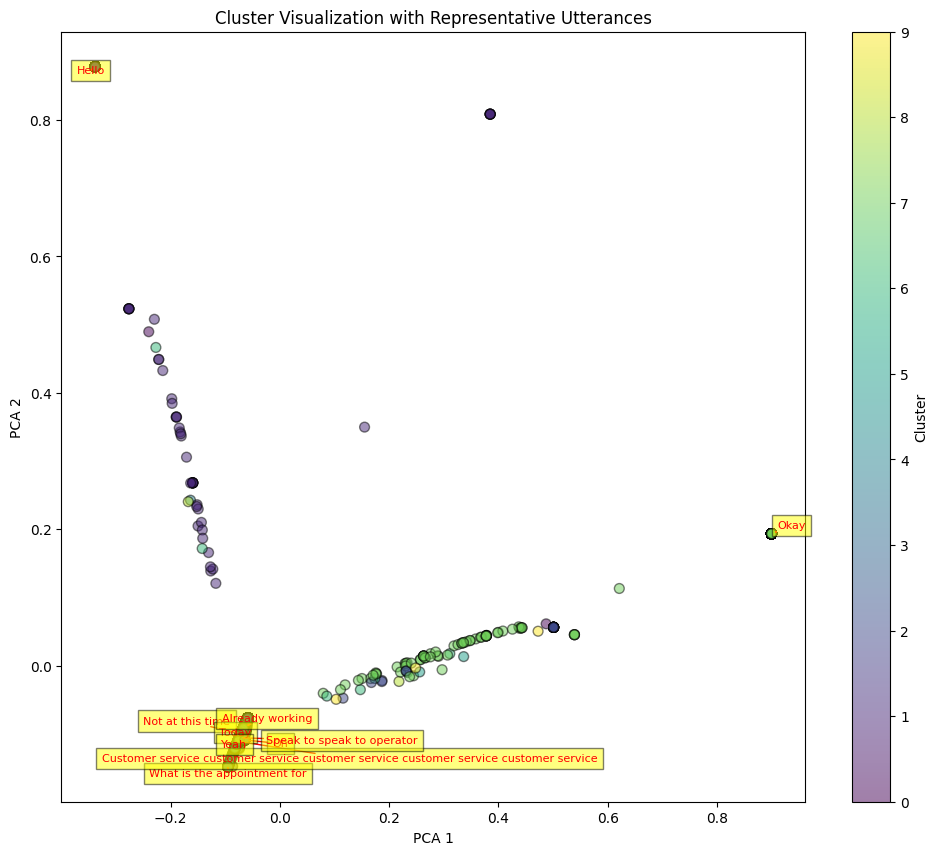

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Reduce the dimensionality of your TF-IDF vectors for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(X.toarray())  # Assuming X is your TF-IDF matrix

# Plot
plt.figure(figsize=(12, 10))  # Increase figure size for better visibility
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=utterances_df['Cluster'], cmap='viridis', alpha=0.5, edgecolor='k', s=50)

# Create a list to hold the text objects for adjustment
texts = []
for index, row in representative_utterances.iterrows():
    texts.append(plt.text(reduced_vectors[index, 0], reduced_vectors[index, 1], s=row['UTTERANCES'], fontdict=dict(color='red', size=8), bbox=dict(facecolor='yellow', alpha=0.5)))

# Use adjust_text to dynamically adjust the text positions
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.title('Cluster Visualization with Representative Utterances')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Adding a color bar to understand which colors represent which clusters
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()


 Refining Rule-Based Enhancements

In [ ]:
# This is conceptual; specific implementation depends on your use case
for i, utterance_vec in enumerate(X):
    # Find the most similar utterance in other clusters
    sim_scores = cosine_similarity(utterance_vec, X)
    # Process similarity scores to find matches (e.g., high-scoring pairs across clusters)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(X)


In [ ]:
import numpy as np

# Assuming `clusters` is a list or array containing the cluster assignment for each utterance
utterances_df['Cluster'] = clusters

high_scoring_pairs = []
threshold = 0.8  # Threshold for considering pairs as highly similar, adjust based on your dataset

for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):  # Compare each utterance with every other utterance
        if similarity_matrix[i, j] > threshold and utterances_df['Cluster'][i] != utterances_df['Cluster'][j]:
            high_scoring_pairs.append((i, j, similarity_matrix[i, j]))

# Sort pairs by similarity score
high_scoring_pairs.sort(key=lambda x: x[2], reverse=True)


<ipython-input-32-35a8c066cfc2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utterances_df['Cluster'] = clusters


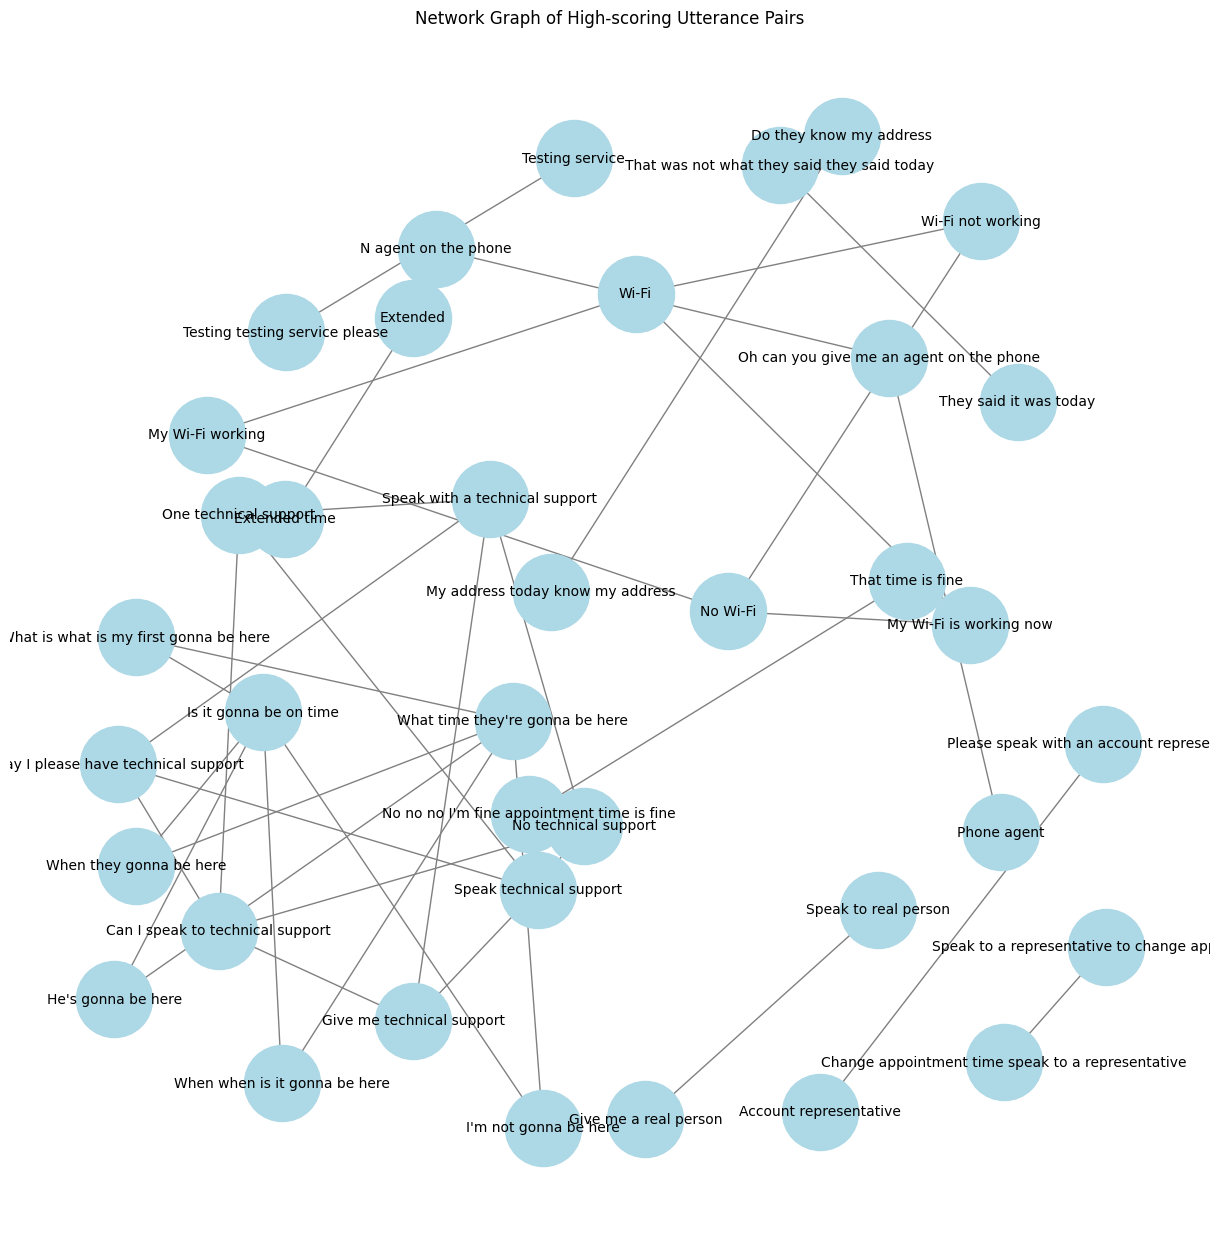

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add nodes with the utterance text as the node label
for i, j, sim_score in high_scoring_pairs[:50]:  # Limiting to top 50 pairs for readability
    G.add_edge(utterances_df['UTTERANCES'][i], utterances_df['UTTERANCES'][j], weight=sim_score)

pos = nx.spring_layout(G, k=0.5, iterations=20)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title('Network Graph of High-scoring Utterance Pairs')
plt.show()


In [ ]:
# For simplicity, let's just print the top N high-scoring pairs
N = 20
for i, j, sim_score in high_scoring_pairs[:N]:
    print(f"Pair: ({utterances_df['UTTERANCES'][i]}, {utterances_df['UTTERANCES'][j]}) - Similarity: {sim_score}")


Pair: (Testing service, Testing testing service please) - Similarity: 0.970607376496269
Pair: (Testing service, Testing testing service please) - Similarity: 0.970607376496269
Pair: (That was not what they said they said today, They said it was today) - Similarity: 0.9645173740753809
Pair: (No no no I'm fine appointment time is fine, That time is fine) - Similarity: 0.9289550373235476
Pair: (Give me a real person, Speak to real person) - Similarity: 0.907173087238146
Pair: (Give me a real person, Speak to real person) - Similarity: 0.907173087238146
Pair: (Speak to a representative to change appointment, Change appointment time speak to a representative) - Similarity: 0.9055948550007552
Pair: (I'm not gonna be here, What time they're gonna be here) - Similarity: 0.9024037698130669
Pair: (I'm not gonna be here, Is it gonna be on time) - Similarity: 0.9024037698130669
Pair: (What time they're gonna be here, When they gonna be here) - Similarity: 0.9024037698130669
Pair: (What time they'r